# Credit Score Simulator with finite samples

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

#### Experimental setup arguments

In [2]:
# Experimental setup arguments

class args:

    # softness parameter for the sigmoid approximating the indicator function, 1 = original, inf = indicator
    loss_softness = 1  # institution, used in SoftLoss and SoftLossThreshUpdater
    utility_softness = 10  # individual, used in SoftUtilityFeatureUpdater

    # risk control parameter
    alpha = 0.2

    # risk control probability (delta_prime)
    delta = 0.25

    # epsilon
    epsilon = 0.01


## Data, strategic features, and model

Import data. Last column of X is a constant.

In [3]:
from data_prep import load_data

path_to_csv_file = './data/cs-training.csv'
X_all, Y_all, data = load_data(path_to_csv_file)

n = X_all.shape[0]
d = X_all.shape[1] - 1

print('n=',n)
print('d=',d)

size = n // 3
X_train, X_cv, Y_train, Y_cv = train_test_split(X_all, Y_all, train_size=size, random_state=42)
del X_all, Y_all

n= 18357
d= 10


Define strategic features

In [ ]:
# strategic feature indices
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# # zero out non-strategic features
# assert model.coef_.shape == (1, d+1) 
# strat_coef = np.zeros((1, d+1))
# strat_coef[0, strat_features] = model.coef_[0, strat_features]

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


Create pretrained classifier: $f_{\theta}$. Train a logistic regression model on train data. Use the rest for calibration and validation.

In [5]:
def train_logistic_regression(X, Y, **kwargs):
    # fit_intercept=False since X already has bias term
    model = LogisticRegression(fit_intercept=False, **kwargs)  # intercept pre-built in X
    model.fit(X, Y)
    assert model.classes_[0] == 0 and model.classes_[1] == 1
    return model

In [ ]:
model = train_logistic_regression(X_train, Y_train)
# example_thresh = 0.5
# Y_proba = model.predict_proba(X_train)[:,1]
# Y_pred = Y_proba > example_thresh
print(model.coef_)

[[ 0.15499726 -0.43268908  1.87709457 -0.01670773 -0.44496005  0.0686525
   1.74889169  0.08651204  0.62787273  0.0802702  -0.36850492]]


In [ ]:
# No regularization: no significant difference
model_no_reg = train_logistic_regression(X_train, Y_train, penalty=None)
print(model_no_reg.coef_)
del model_no_reg

[[ 0.1611591  -0.43315984  1.89748597 -0.0168386  -0.44851936  0.06981306
   1.78715521  0.08727664  0.63050177  0.07989456 -0.36899056]]


In [8]:
import pandas as pd
pd.DataFrame({
    # 'index': range(d+1),
    'feature': np.concatenate((data.columns[1:], ['bias'])),  # replace label w/ const
    'strategic': ['yes' if i in strat_features else 'no' for i in range(d+1)],
    'model_coef': model.coef_[0]
})

,feature,strategic,model_coef
0,RevolvingUtilizationOfUnsecuredLines,yes,0.154997
1,age,no,-0.432689
2,NumberOfTime30-59DaysPastDueNotWorse,no,1.877095
3,DebtRatio,no,-0.016708
4,MonthlyIncome,no,-0.444960
5,NumberOfOpenCreditLinesAndLoans,yes,0.068652
6,NumberOfTimes90DaysLate,no,1.748892
7,NumberRealEstateLoansOrLines,yes,0.086512
8,NumberOfTime60-89DaysPastDueNotWorse,no,0.627873
9,NumberOfDependents,no,0.080270


In [ ]:
model.coef_[0][strat_features]

array([0.15499726, 0.0686525 , 0.08651204])

Define utility functions

In [23]:
# f(theta^T x)
# Utility: u(x, lambda) = softmax(gamma * (1 - lambda  - f(theta^T x)  ))
from typing import Union
from rcpp_utils import *

In [11]:
from sklearn.metrics import accuracy_score

Y_proba = model.predict_proba(X_train)[:,1]
Y_pred = Y_proba > 0.5

example_thresh = 0.5
print(f" ----- example_thresh = {example_thresh} -----")
for softness in [1, 2, 4, 7, 10, 20, 40, 70, 100, 1000]:
    soft_loss = SoftLoss(softness)
    print(f"Soft loss @ softness = {softness}: ", soft_loss(Y_train, Y_proba, example_thresh))

print("Train accuracy: ", accuracy_score(Y_train, Y_pred))
print("Type II error: ", type_II_error(Y_train, Y_pred))

 ----- example_thresh = 0.5 -----
Soft loss @ softness = 1:  0.2212287909639273
Soft loss @ softness = 2:  0.21407477038341932
Soft loss @ softness = 4:  0.20327033225012994
Soft loss @ softness = 7:  0.19557041846927176
Soft loss @ softness = 10:  0.1936510633188461
Soft loss @ softness = 20:  0.19601770910010125
Soft loss @ softness = 40:  0.19982450768556734
Soft loss @ softness = 70:  0.20146007102558766
Soft loss @ softness = 100:  0.20185367237164673
Soft loss @ softness = 1000:  0.20199477508487007
Train accuracy:  0.7269161627716947
Type II error:  0.20183036443863375


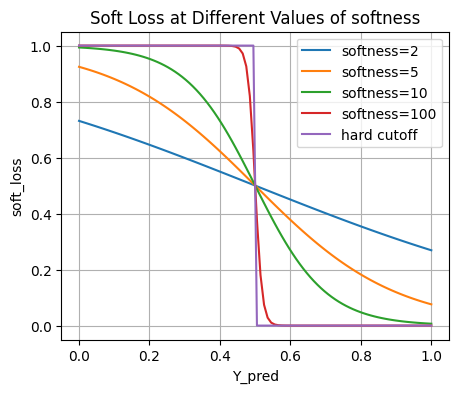

In [12]:
threshold = 0.5
Y_proba_sample = np.linspace(0, 1, 100)

plt.figure(figsize=(5,4))
for softness in [2, 5, 10, 100]:
    plt.plot(Y_proba_sample, sigmoid(softness * (1 - threshold - Y_proba_sample)), label=f'softness={softness}')
# indicator
plt.plot(Y_proba_sample, (Y_proba_sample <= threshold).astype(int), label='hard cutoff')

plt.xlabel('Y_pred')
plt.ylabel('soft_loss')
plt.title('Soft Loss at Different Values of softness')
plt.legend()
plt.grid(True)
plt.show()

## Simulations

#### Risk Control Under Performativity

- Distributional changes under algorithm: store histograms


- Visualize distribution changes under algorithm
- Compare to binary search
    - empirical loss through iterations
    - soft loss / hard loss on threshold throughout iterations
- Experiment w/ different epsilon's, softness

In [24]:
class Logger:
    def __init__(self):
        self.data = {}

    def update(self, step, values):
        for key, value in values.items():
            if key not in self.data:
                self.data[key] = {}
            self.data[key][step] = value

    def get_data(self, key):
        sorted_data = sorted(self.data[key].items())
        return zip(*sorted_data)  # steps, values

Main runner

In [42]:
def run_iters(soft_loss: SoftLoss, thresh_updater: ThreshUpdater, features_updater: FeaturesUpdater,
              model: LogisticRegression, X_cv, Y_cv, args, random_state=42, cal_size=3000,
              total_iter=20, thresh_init=1.):
    """
    model: pretrained logistic regression
    X, Y: data
    total_iter: number of steps
    random_state: random seed for splitting data
    method: 'ubc' or 'bin_search'
    """

    def get_loss_and_type_II_error(Y, Y_proba_iter, thresh):
        loss = soft_loss(Y, Y_proba_iter, thresh)
        t2_error = type_II_error(Y, Y_proba_iter > thresh)
        return loss, t2_error
    
    thresh = thresh_init

    logger = Logger()

    # calibration/validation split
    X_cal, X_val, Y_cal, Y_val = train_test_split(X_cv, Y_cv, train_size=cal_size, random_state=random_state)
    # Get initial histogram
    Y_val_proba = model.predict_proba(X_val)[:,1]
    Y_cal_proba = model.predict_proba(X_cal)[:,1]
    logger.update(0,
                  {
                      "Y_cal_proba": Y_cal_proba, "Y_val_proba": Y_val_proba,
                      "Y_cal": Y_cal, "Y_val": Y_val,
                      "thresh": thresh
                  })

    for iter in range(total_iter):

        # Deploy threshold of time t and get data of time t
        X_val_iter = features_updater.best_response(X_val, Y_val_proba, thresh)
        X_cal_iter = features_updater.best_response(X_cal, Y_cal_proba, thresh)
        Y_val_proba_iter = model.predict_proba(X_val_iter)[:,1]
        Y_cal_proba_iter = model.predict_proba(X_cal_iter)[:,1]

        # Update threshold t -> t+1
        thresh_new = thresh_updater.get_thresh_predeploy(Y_cal, Y_cal_proba_iter)

        # Evaluate to get empirical risk on cal set and a proxy for population risk (using updated thresh)
        # Assume ground truth doesn't change
        perf = {}
        for t_, suffix_ in zip([thresh, thresh_new], ["", "_new"]):
            perf["loss_cal" + suffix_], perf["t2_error_cal" + suffix_] = get_loss_and_type_II_error(Y_cal, Y_cal_proba_iter, t_)
            perf["loss_val" + suffix_], perf["t2_error_val" + suffix_] = get_loss_and_type_II_error(Y_val, Y_val_proba_iter, t_)

        thresh_updater.update_postdeploy(perf['loss_cal'] > args.alpha)
        thresh = thresh_new

        # Log
        log = {"Y_cal_proba": Y_cal_proba_iter, "Y_val_proba": Y_val_proba_iter, "Y_cal": Y_cal, "Y_val": Y_val,
                "thresh": thresh}
        log.update(perf)
        logger.update(iter+1, log)

    return logger

Viz code

In [43]:
def plot_histogram_evolution(logger, ax, title, bounds=0.05):

    _, Y_cal_proba = logger.get_data("Y_cal_proba")
    _, thresh_all = logger.get_data("thresh")
    # _, Y_cal = logger.get_data("Y_cal")

    # plot around the last threshold
    last_thresh = thresh_all[-1]

    window_low, window_high = last_thresh - bounds, last_thresh + bounds
    # Y_cal_proba = [Y_cal_proba_iter[(Y_cal_proba_iter >= window_low) & (Y_cal_proba_iter <= window_high)]
    #                  for Y_cal_proba_iter in Y_cal_proba]
    
    Y_cal_hist = [np.histogram(Y_cal_proba_iter, np.linspace(window_low, window_high, 101))[0] 
                  for Y_cal_proba_iter in Y_cal_proba]    

    hist_data = np.array(Y_cal_hist)

    # Plot heatmap
    ax.imshow(hist_data.T, aspect='auto', cmap='viridis', origin='lower')
    ax.plot(range(len(thresh_all)),
            (100 * (1 - np.array(thresh_all)) - 100 * window_low) / (100 * (window_high - window_low)),
            color='red', linestyle="--", linewidth=2, label=r'1-$\lambda$')

    yticks = np.linspace(0, 100, 11)  # Tick positions on the 0-100 scale
    yticklabels = [f"{y/100:.1f}" for y in yticks]  # Format tick labels to 2 decimal places
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    ax.set_title(title)
    ax.set_xlabel('iteration')
    ax.set_ylabel('predicted default probability')
    ax.legend()


def print_thresh(logger, **kwargs):
    _, thresh_all = logger.get_data("thresh")
    string_kwargs = ", ".join([f"{key}={value}" for key, value in kwargs.items()])
    print(f"Thresholds ({string_kwargs}): ", end="")
    for thresh in thresh_all:
        print(f"{thresh:.4f}", end=", ")
    print()


In [44]:
def plot_histogram_evolution(logger, title='histogram evolution', window=(0, 1)):
    import seaborn as sns

    steps, Y_cal_proba = logger.get_data("Y_cal_proba")
    _, thresh_all = logger.get_data("thresh")
    # _, Y_cal = logger.get_data("Y_cal")

    # plot around the last threshold
    last_thresh = thresh_all[-1]

    window_low, window_high = window

    # Create subplots
    fig, axes = plt.subplots(1, len(thresh_all), figsize=(12, 4), sharex=True, sharey=True)

    # Flatten axes array for easy indexing
    axes = axes.flatten()

    # Plot each distribution in its own subplot
    for i, t in enumerate(steps):
        ax = axes[i]
        sns.kdeplot(y=Y_cal_proba[t], ax=ax, fill=True, bw_adjust=0.1, alpha=0.7, color='skyblue')
        
        if i == 0:
            ax.set_ylabel('predicted default probability')  # Set label for the first subplot
            ax.spines['left'].set_visible(True)  # Show the left spine
            ax.tick_params(axis='y', which='both', length=4)  # Show ticks on the y-axis
        else:
            ax.spines['left'].set_visible(False)  # Hide the left spine for other plots
            ax.tick_params(axis='y', left=False)  # Remove y-axis ticks
            # ax.set_yticks([])  # Remove y-axis labels

        ax.spines['top'].set_visible(False)  # Remove top spine
        ax.spines['right'].set_visible(False)  # Remove right spine
        ax.spines['bottom'].set_visible(False)  # Remove bottom spine
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_xlabel(None)
        ax.set_title(f't={t}')  # Set title with time step
        ax.set_ylim(window_low, window_high)  # Set y-axis limits

        ax.axhline(y=1 - thresh_all[t], color='red', linestyle='--')  # Add horizontal line for threshold

    # Add a global title and adjust layout
    fig.suptitle('histogram evolution', fontsize=16, y=0.95)
    fig.tight_layout()
    fig.show()


In [87]:
def show_loss_over_iter(logger, alpha, delta, n=5000, offset=0.01):
    """
    alpha: risk control level
    delta: risk conrol probability (1 - delta = probability)
    """
    steps, loss_cal = logger.get_data("loss_cal")
    _, loss_cal_new = logger.get_data("loss_cal_new")
    _, loss_val = logger.get_data("loss_val")
    _, loss_val_new = logger.get_data("loss_val_new")
    # _, type_II_error_cal = logger.get_data("t2_error_cal_new")
    # _, type_II_error_val = logger.get_data("t2_error_val_new")
    steps = np.array(steps)

    plt.figure(figsize=(5, 4))
    plt.rcParams['text.usetex'] = False

    # Risk to control
    plt.axhline(alpha, color='r', linestyle='--', label=r'$\alpha$')

    hoeff_risk = alpha - np.sqrt((1. / 2 / n) * np.log(1 / delta))
    plt.axhline(hoeff_risk, color='gray', linestyle='--', label="ucb bound")

    # Calibration
    for i in range(len(steps)-1):
        # distribution shift
        plt.plot([steps[i]+offset, steps[i+1]-offset], [loss_cal_new[i], loss_cal[i+1]],
                    'g*--', label='calibration' if i == 0 else '')
    for i in range(1, len(steps)):
        # optimization step
        plt.plot([steps[i]-offset, steps[i]+offset], [loss_cal[i], loss_cal_new[i]], 'g-')

    # Validation
    for i in range(len(steps)-1):
        plt.plot([steps[i]+offset, steps[i+1]-offset], [loss_val_new[i], loss_val[i+1]],
                    'b*--', label='validation' if i == 0 else '')
    for i in range(1, len(steps)):
        plt.plot([steps[i]-offset, steps[i]+offset], [loss_val[i], loss_val_new[i]], 'b-')

    # plt.plot(steps, loss_cal, label='calibration soft loss', color='b')
    # plt.plot(steps, loss_cal_new, label='calibration soft loss new', color='r')
    # plt.plot(steps, loss_val, label='validation soft loss', color='g')
    # plt.plot(steps, type_II_error_cal, label='calibration hard loss', color='b', linestyle='--')
    # plt.plot(steps, type_II_error_val, label='validation hard loss', color='g', linestyle='--')

    plt.xlabel('Steps')
    plt.ylabel('Soft Loss')
    plt.title(rf'Soft Loss over Iterations ($\alpha={alpha}$, $\delta={delta}$)')
    plt.legend()
    plt.grid(True)
    plt.show()

threshold trajectory:  (1.0, 0.5023150444030762, 0.5840029716491699, 0.5771241188049316, 0.5783066749572754, 0.5781111717224121)


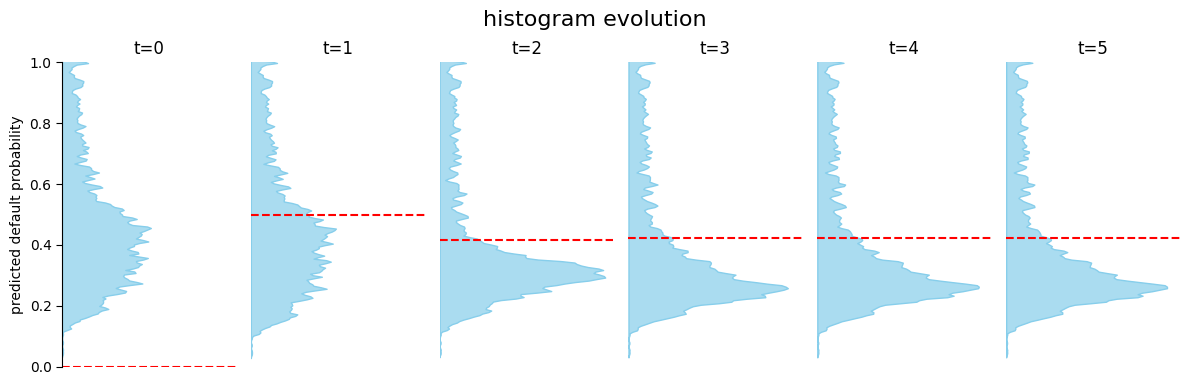

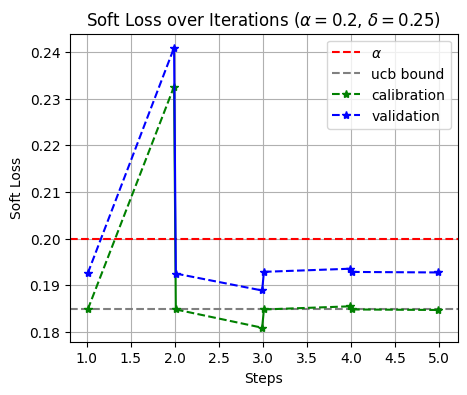

In [90]:
# Original

args.loss_softness = 10
args.epsilon = 100

random_state = 123
soft_loss = SoftLoss(args.loss_softness)
thresh_updater = SoftLossThreshUpdater(soft_loss, args.delta, args.alpha)
features_updater = SoftUtilityFeaturesUpdater(model, strat_features, args.epsilon, utility_softness=args.utility_softness)
results = run_iters(soft_loss, thresh_updater, features_updater, model,
                    X_cv, Y_cv, args, random_state=random_state, total_iter=5)

steps, Y_cal_proba = results.get_data("Y_cal_proba")
_, Y_cal = results.get_data("Y_cal")
_, threshs = results.get_data("thresh")
print("threshold trajectory: ", threshs)

plot_histogram_evolution(results, title='histogram evolution', window=(0,1))
show_loss_over_iter(results, args.alpha, args.delta, n=len(Y_cal[0]))

eps=0.01, num_iter=300
threshold trajectory:  (1.0, 0.4976201057434082, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49762868881225586, 0.49

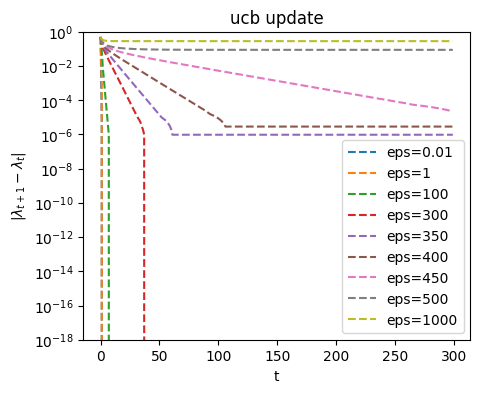

In [131]:
# Figure 2: repeated risk minimization @ different eps levels

def get_eps_results(soft_loss, thresh_updater, rs, eps, num_iter):
    eps_features_updater = SoftUtilityFeaturesUpdater(model, strat_features, eps, utility_softness=args.utility_softness)
    results = run_iters(soft_loss, thresh_updater, eps_features_updater, model,
                        X_cv, Y_cv, args, random_state=rs, total_iter=num_iter)
    _, thresh = results.get_data("thresh")
    return thresh

random_state = 123
epsilons = [0.01, 1, 100, 300, 350, 400, 450, 500, 1000]
num_iters = [300] * len(epsilons)  #[70, 70, 70, 70, 70, 70, 70, 70, 70]
# epsilons = [0.01, 1]
# num_iters = [70, 70]

trajectories = {}
for eps, num_iter in zip(epsilons, num_iters):
    print(f"eps={eps}, num_iter={num_iter}")
    soft_loss = SoftLoss(args.loss_softness)
    thresh_updater = SoftLossThreshUpdater(soft_loss, args.delta, args.alpha)
    threshs = get_eps_results(soft_loss, thresh_updater, random_state, eps, num_iter)
    trajectories[eps] = threshs
    print("threshold trajectory: ", threshs)


# difference between consecutive thresholds
diffs = {eps: np.diff(traj) for eps, traj in trajectories.items()}
# plot absolute differences on log scale
plt.figure(figsize=(5,4))
for eps, diff in diffs.items():
    style = '*--' if len(diff) < 7 else '--'
    plt.plot(range(len(diff)), np.abs(diff), style, label=f'eps={eps}')
plt.yscale('log')
# set y scale
plt.ylim(1e-18, 1)
plt.xlabel('t')
plt.ylabel(r'|$\lambda_{t+1} - \lambda_t$|')
# plt.ylabel('abs diff in threshold')
plt.title('ucb update')
plt.legend()

# setting the floats

### Binary search

threshold trajectory:  (1.0, 0.5, 0.25, 0.375, 0.4375, 0.46875, 0.484375, 0.4921875, 0.49609375, 0.498046875, 0.4990234375, 0.49951171875, 0.499755859375, 0.4998779296875, 0.49993896484375, 0.499969482421875)


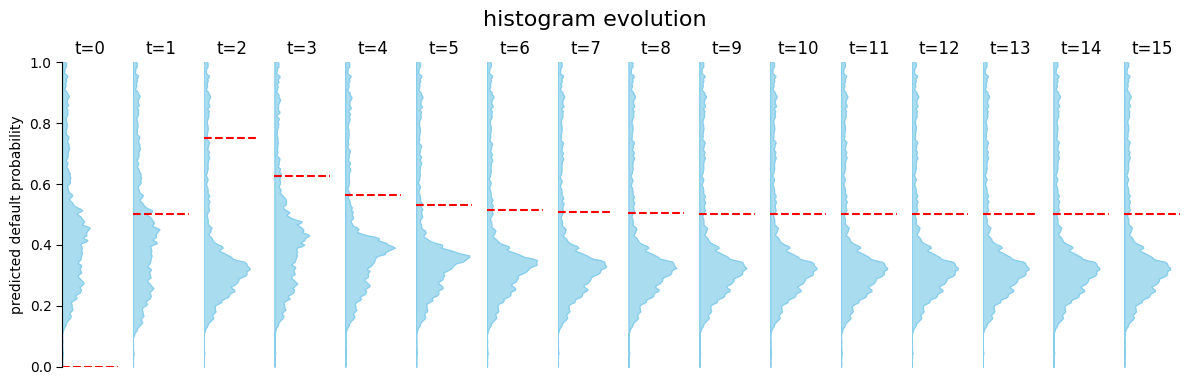

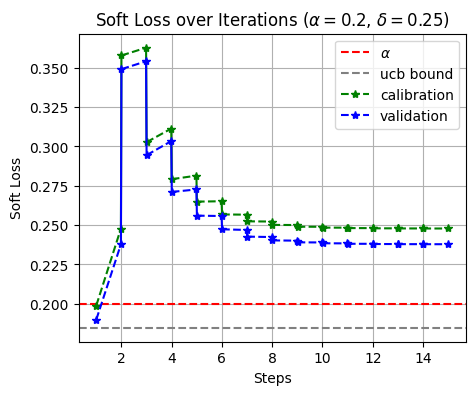

In [133]:
args.loss_softness = 10
args.epsilon = 100

random_state = 100
soft_loss = SoftLoss(args.loss_softness)
thresh_updater = BinaryThreshUpdater(0, 1)
features_updater = SoftUtilityFeaturesUpdater(model, strat_features, args.epsilon, utility_softness=args.utility_softness)
results = run_iters(soft_loss, thresh_updater, features_updater, model,
                    X_cv, Y_cv, args, random_state=random_state, total_iter=15)

steps, Y_cal_proba = results.get_data("Y_cal_proba")
_, Y_cal = results.get_data("Y_cal")
_, threshs = results.get_data("thresh")
print("threshold trajectory: ", threshs)

plot_histogram_evolution(results, title='histogram evolution', window=(0,1))
show_loss_over_iter(results, args.alpha, args.delta, n=len(Y_cal[0]))

eps=0.01, num_iter=100
threshold trajectory:  (1.0, 0.5, 0.25, 0.125, 0.1875, 0.21875, 0.234375, 0.2421875, 0.24609375, 0.248046875, 0.2490234375, 0.24951171875, 0.249755859375, 0.2498779296875, 0.24993896484375, 0.249969482421875, 0.2499847412109375, 0.24999237060546875, 0.24999618530273438, 0.2499980926513672, 0.2499990463256836, 0.2499995231628418, 0.2499997615814209, 0.24999988079071045, 0.24999994039535522, 0.2499999701976776, 0.2499999850988388, 0.2499999925494194, 0.2499999962747097, 0.24999999813735485, 0.24999999906867743, 0.2499999995343387, 0.24999999976716936, 0.24999999988358468, 0.24999999994179234, 0.24999999997089617, 0.24999999998544808, 0.24999999999272404, 0.24999999999636202, 0.249999999998181, 0.2499999999990905, 0.24999999999954525, 0.24999999999977263, 0.2499999999998863, 0.24999999999994316, 0.24999999999997158, 0.2499999999999858, 0.2499999999999929, 0.24999999999999645, 0.24999999999999822, 0.2499999999999991, 0.24999999999999956, 0.24999999999999978, 0.249999

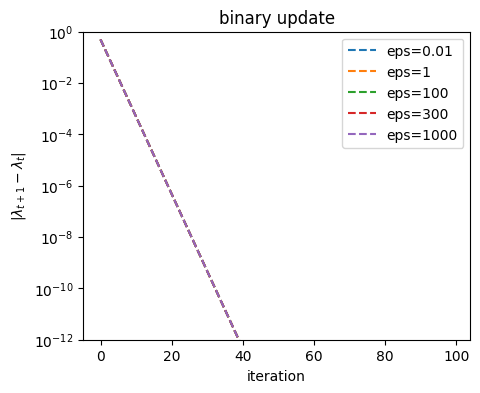

In [123]:
random_state = 123
epsilons = [0.01, 1, 100, 300, 1000]
num_iters = [100] * 5  # [5, 5, 10, 70, 70]

trajectories = {}
for eps, num_iter in zip(epsilons, num_iters):
    print(f"eps={eps}, num_iter={num_iter}")
    soft_loss = SoftLoss(args.loss_softness)
    thresh_updater = BinaryThreshUpdater(0, 1)
    threshs = get_eps_results(soft_loss, thresh_updater, random_state, eps, num_iter)
    trajectories[eps] = threshs
    print("threshold trajectory: ", threshs)


# difference between consecutive thresholds
diffs = {eps: np.diff(traj) for eps, traj in trajectories.items()}
# plot absolute differences on log scale
plt.figure(figsize=(5,4))
for eps, diff in diffs.items():
    style = '*--' if len(diff) < 7 else '--'
    plt.plot(range(len(diff)), np.abs(diff), style, label=f'eps={eps}')
plt.yscale('log')
# set y scale
plt.ylim(1e-12, 1)
plt.xlabel('iteration')
plt.ylabel(r'|$\lambda_{t+1} - \lambda_t$|')
plt.title('binary update')
plt.legend()

In [26]:
# x - eps * theta
# model.predict_proba(X_cv)

array([[0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 8.54762267e-80],
       ...,
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00]])

[[-107.54225883 -376.20782859 1732.31214653  -72.19678262 -449.29669554
    15.03834405 1333.64899375   80.16275064 -283.71445171   80.2773496
  -341.94238419]]
threshold trajectory:  (1.0, 0.8020262718200684, 0.8065552711486816, 0.8064379692077637, 0.8064408302307129, 0.8064408302307129)


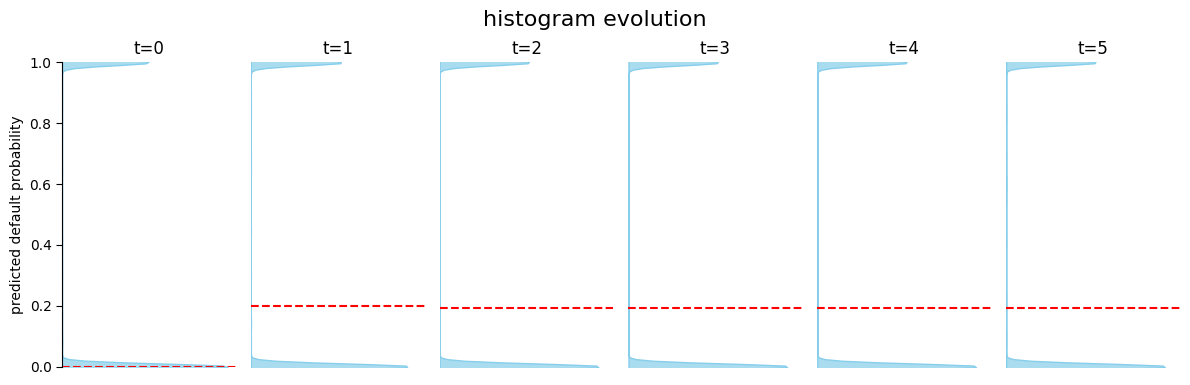

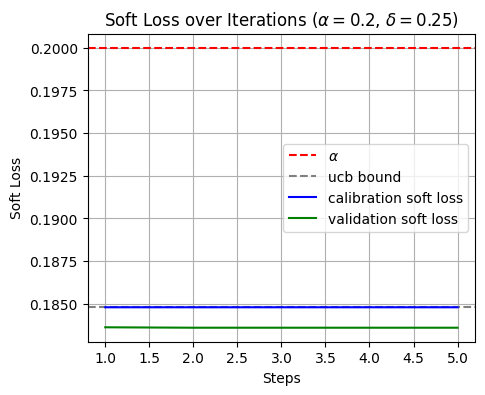

In [24]:
# No cost features update (best case for maximizing distribution shift)

model = train_logistic_regression(X_train, Y_train)
model.coef_ *= 1000
print(model.coef_)

args.loss_softness = 1
args.epsilon = 5e-1

random_state = 124
soft_loss = SoftLoss(args.loss_softness)
thresh_updater = SoftLossThreshUpdater(soft_loss, args.delta, args.alpha)
features_updater = NoCostFeaturesUpdater(model, strat_features, args.epsilon)
results = run_iters(soft_loss, thresh_updater, features_updater, model,
                    X_cv, Y_cv, args, random_state=random_state, total_iter=5)

steps, Y_cal_proba = results.get_data("Y_cal_proba")
_, Y_cal = results.get_data("Y_cal")
_, threshs = results.get_data("thresh")
print("threshold trajectory: ", threshs)

plot_histogram_evolution(results, title='histogram evolution', window=(0,1))
show_loss_over_iter(results, args.alpha, args.delta, n=len(Y_cal[0]))

threshold trajectory:  (1.0, 0.5, 0.25, 0.375, 0.4375, 0.46875)
0.3025 0.76


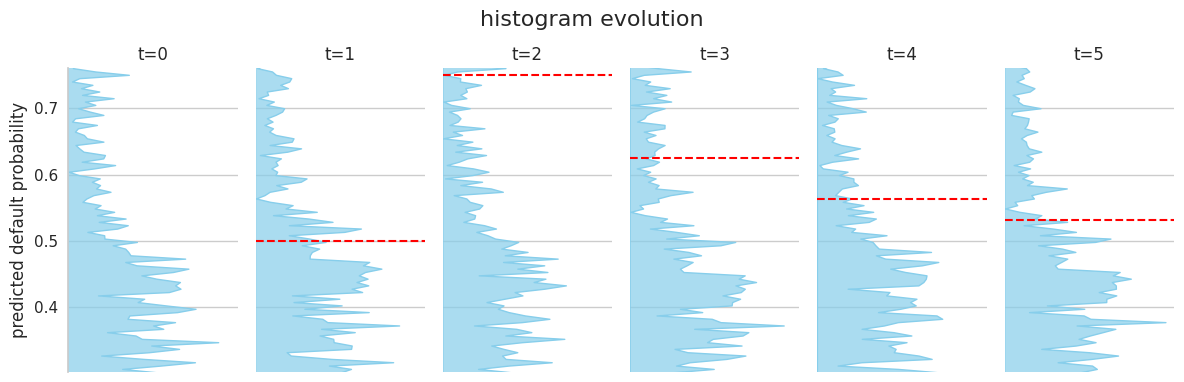

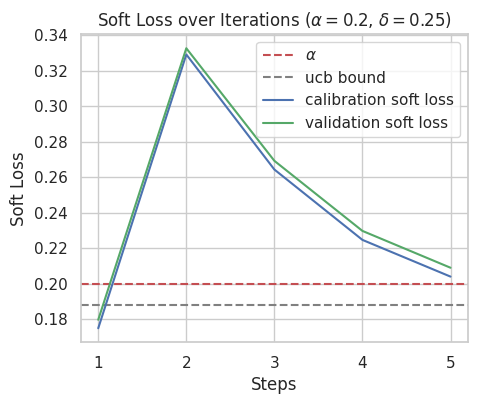

In [281]:
# binary
args.epsilon = 1

random_state = 124
soft_loss = SoftLoss(args.loss_softness)
thresh_updater = BinaryThreshUpdater(0, 1)
features_updater = NoCostFeaturesUpdater(model, strat_features, args.epsilon)
results = run_iters(soft_loss, thresh_updater, features_updater, model,
                    X_cv, Y_cv, args, random_state=random_state, total_iter=5)

steps, Y_cal_proba = results.get_data("Y_cal_proba")
_, Y_cal = results.get_data("Y_cal")
_, threshs = results.get_data("thresh")
print("threshold trajectory: ", threshs)

plot_histogram_evolution(results, title='histogram evolution')
show_loss_over_iter(results, args.alpha, args.delta)

In [87]:
# algorithm aproach

# 2 important parameters: epsilon and utility softness

# If utility softness is too low, the utility function becomes "linear". This diminishes the effect
# of different lambdas on the distribution shift. This means after one-two iterations, the threshold
# converges.

# If the utility softness is higher, then epsilon needs to be larger b/c the utility function's
# derivatives are smaller. Too large epsilon (eps > 1) is not guaranteed by the theory.

def show_eps_plots(epsilons, utility_softness):

    fig, axs = plt.subplots(2, 3, figsize=(8, 6))

    for idx, epsilon in enumerate(epsilons):
        args.utility_softness = utility_softness
        args.epsilon = epsilon
        logger = run_iters(model, X_cv, Y_cv, args, total_iter=5, random_state=42, cal_size=3000)
        print_thresh(logger, epsilon=epsilon, utility_softness=args.utility_softness)

        fig.suptitle(r'$f_{\theta}(x)$ histogram evolution ($\gamma=$' + f"{args.utility_softness})")
        i, j = idx // 3, idx % 3
        plot_histogram_evolution(logger, axs, i, j, title=r'$\epsilon=$' + str(epsilon))
    plt.tight_layout()
    plt.show()
    

In [ ]:
epsilons = np.array([1e-2, 1e-1, 2e-1, 5e-1, 8e-1, 1, 100]) * 100
show_eps_plots(epsilons, utility_softness=10)

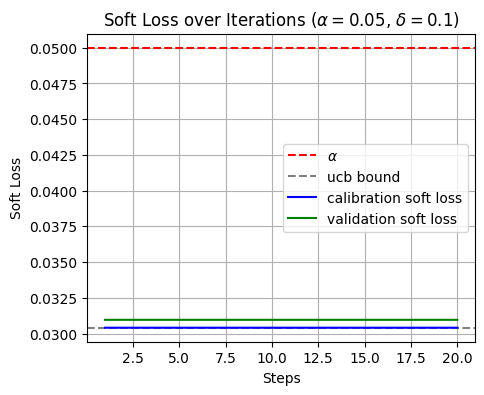

In [ ]:
show_loss_over_iter(logger, args.alpha, args.delta, n=3000)

#### Binary search

Thresholds: 1.0000, 0.5000, 0.7500, 0.8750, 0.8125, 0.7812, 0.7656, 0.7734, 0.7695, 0.7676, 0.7686, 0.7690, 0.7693, 0.7692, 0.7692, 0.7692, 0.7692, 0.7692, 0.7692, 0.7692, 0.7692, 

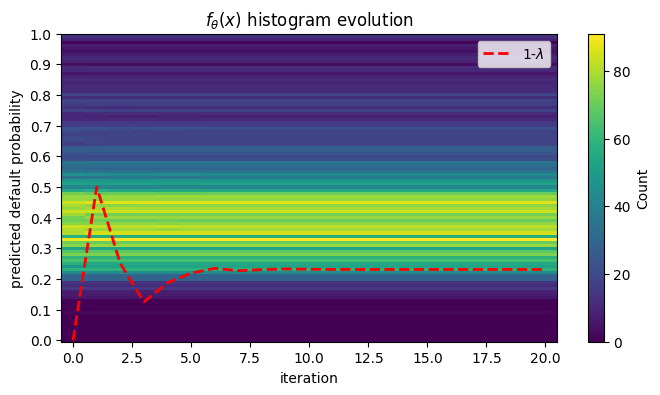

In [53]:
# Run over different seeds
# Run over binary search

bin_search_logger = run_iters(model, X_cv, Y_cv, args, total_iter=20, random_state=42, cal_size=3000, method='bin_search')
print_thresh(bin_search_logger)
plot_histogram_evolution(bin_search_logger)

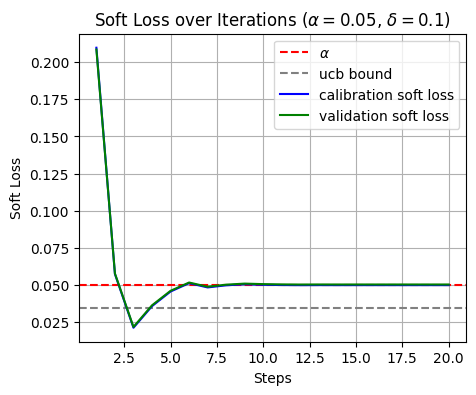

In [54]:
show_loss_over_iter(bin_search_logger, args.alpha, args.delta)

#### Confidence Bounds

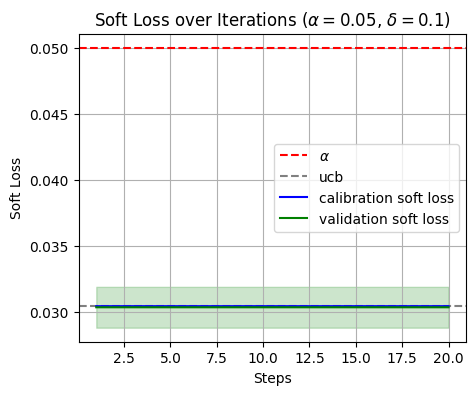

In [57]:
alpha = args.alpha
delta = args.delta
n = 3000


loggers = [
    run_iters(model, X_cv, Y_cv, args, total_iter=20, random_state=i, method='ucb') for i in range(100)
]

plt.figure(figsize=(5, 4))
plt.rcParams['text.usetex'] = False


loss_cals, loss_vals, type_II_error_cals, type_II_error_vals = [], [], [], []

for logger in loggers:
    steps, loss_cal = logger.get_data("loss_cal")
    _, loss_val = logger.get_data("loss_val")
    _, type_II_error_cal = logger.get_data("type_II_error_cal")
    _, type_II_error_val = logger.get_data("type_II_error_val")
    loss_cals.append(loss_cal)
    loss_vals.append(loss_val)
    type_II_error_cals.append(type_II_error_cal)
    type_II_error_vals.append(type_II_error_val)

# Collapse to find mean and std
loss_cals_mean = np.mean(loss_cals, axis=0)
loss_vals_mean = np.mean(loss_vals, axis=0)
type_II_error_cals_mean = np.mean(type_II_error_cals, axis=0)
type_II_error_vals_mean = np.mean(type_II_error_vals, axis=0)

loss_cals_std = np.std(loss_cals, axis=0)
loss_vals_std = np.std(loss_vals, axis=0)
type_II_error_cals_std = np.std(type_II_error_cals, axis=0)
type_II_error_vals_std = np.std(type_II_error_vals, axis=0)


# Risk to control
plt.axhline(alpha, color='r', linestyle='--', label=r'$\alpha$')
hoeff_risk = alpha - np.sqrt((1. / 2 / n) * np.log(1 / args.delta))
plt.axhline(hoeff_risk, color='gray', linestyle='--', label="ucb")

plt.plot(steps, loss_cals_mean, label='calibration soft loss', color='b')
plt.plot(steps, loss_vals_mean, label='validation soft loss', color='g')
plt.fill_between(steps, loss_cals_mean - loss_cals_std, loss_cals_mean + loss_cals_std, color='b', alpha=0.2)
plt.fill_between(steps, loss_vals_mean - loss_vals_std, loss_vals_mean + loss_vals_std, color='g', alpha=0.2)

# plt.plot(steps, type_II_error_cal, label='calibration hard loss', color='b', linestyle='--')
# plt.plot(steps, type_II_error_val, label='validation hard loss', color='g', linestyle='--')

plt.xlabel('Steps')
plt.ylabel('Soft Loss')
plt.title(rf'Soft Loss over Iterations ($\alpha={alpha}$, $\delta={delta}$)')
plt.legend()
plt.grid(True)
plt.show()